In [1]:
import numpy as np
import pandas as pd
from model.autoencoder import AutoEncoder
from model.vae import VAE
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
import diffusion_dist as diff
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
pd_atac = pd.read_csv('./data/expr_atac_processed.csv', index_col=0)
pd_rna = pd.read_csv('./data/expr_rna_processed.csv', index_col=0)
atac = pd_atac.to_numpy()
rna = pd_rna.to_numpy()

In [3]:
def pairwise_distance(x):
    x_norm = (x**2).sum(1).view(-1, 1)
    y_norm = x_norm.view(1, -1)
    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(x, 0, 1))
    return dist 

In [47]:
class scDataset(Dataset):

    def __init__(self, atac_seq_file = "./data/expr_atac_processed.csv", rna_seq_file = "./data/expr_rna_processed.csv", standardize = False):
        self.expr_ATAC = pd.read_csv(atac_seq_file, index_col=0).to_numpy()
        self.expr_RNA = pd.read_csv(rna_seq_file, index_col=0).to_numpy()
        # standardize
        if standardize:
            self.expr_ATAC = StandardScaler().fit_transform(self.expr_ATAC)
            self.expr_RNA = StandardScaler().fit_transform(self.expr_RNA)
            print(self.expr_RNA)
    
        self.expr_ATAC = latent_semantic_indexing(self.expr_ATAC, k=1000)

        # self.transform = transform
        self.expr_ATAC = torch.FloatTensor(self.expr_ATAC)
        self.expr_RNA = torch.FloatTensor(self.expr_RNA)
        
    def __len__(self):
        # number of cells
        return len(self.expr_ATAC)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # index denote the index of the cell
        sample = {'ATAC': self.expr_ATAC[idx,:], 'RNA':self.expr_RNA[idx,:], 'index':idx}
        
        # if self.transform:
        #     sample = self.transform(sample)
        
        return sample

# # transform
# class standardize(object):

#     def __call__(self, sample):
#         sample_ATAC = StandardScaler().fit_transform(sample['ATAC'][None,:])
#         sample_RNA = StandardScaler().fit_transform(sample['RNA'][None,:])
#         return {'ATAC': torch.from_numpy(sample_ATAC.squeeze()), 'RNA':torch.from_numpy(sample_RNA.squeeze())}

## Diffusion distance

In [5]:
def latent_semantic_indexing(doc_matrix, k):
    """\
        Compute LSI, i.e. SVD on document matrix

        Parameters:
            doc_matrix: term by document count matrix
        Returns:
            latent: document latent matrix
    """
    doc_matrix = doc_matrix.T
    count = np.count_nonzero(doc_matrix, axis=1)
    count = np.log(doc_matrix.shape[1] / count)
    doc_matrix = doc_matrix * count[:,None]

    from scipy.linalg import svd
    U, S, Vh = svd(doc_matrix, full_matrices = False, compute_uv = True)
    latent = np.matmul(Vh[:k, :].T, np.diag(S[:k]))
    return latent

In [6]:
pca = PCA(n_components=30)
atac_latent = pca.fit_transform(atac)

In [7]:
diffu_atac = diff.diffusion_map(atac_latent, n_eign = 10, alpha = 150, diffusion_time = 5)
diff_sim_atac = diff.diffusion_similarity(diffu_atac)
diff_sim_atac = diff_sim_atac / diff_sim_atac.max() 

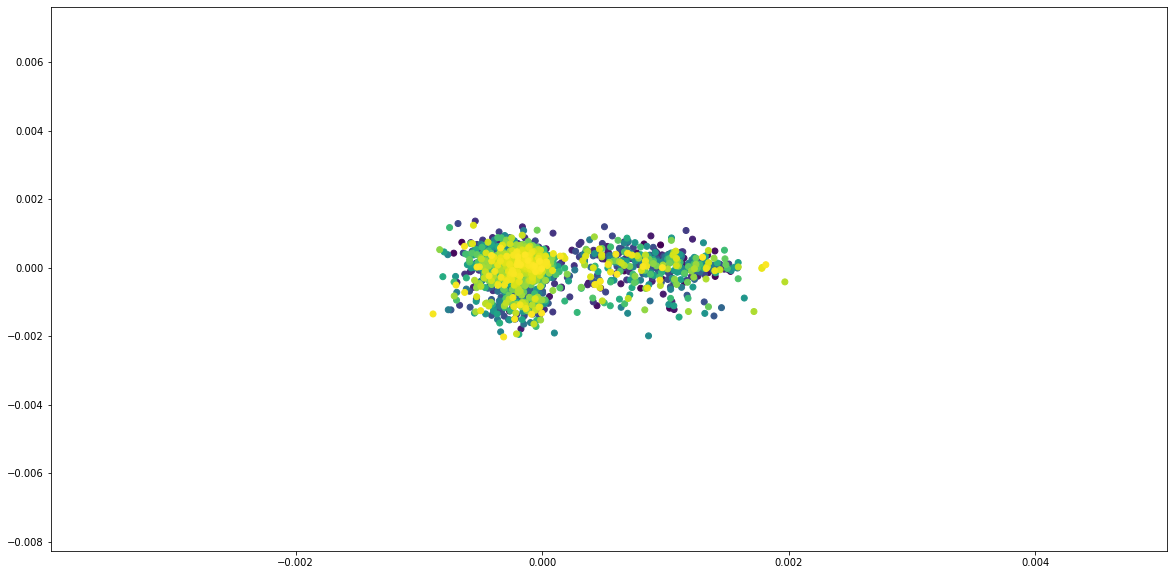

In [8]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(diffu_atac[:,2], diffu_atac[:,3], c=np.arange(atac.shape[0]))

In [9]:
pca = PCA(n_components=30)
rna_latent = pca.fit_transform(np.log1p(rna))

In [10]:
diffu = diff.diffusion_map(rna_latent, n_eign = 10, alpha = 15, diffusion_time = 5)
diff_sim_rna = diff.diffusion_similarity(diffu)
diff_sim_rna = diff_sim_rna / diff_sim_rna.max()

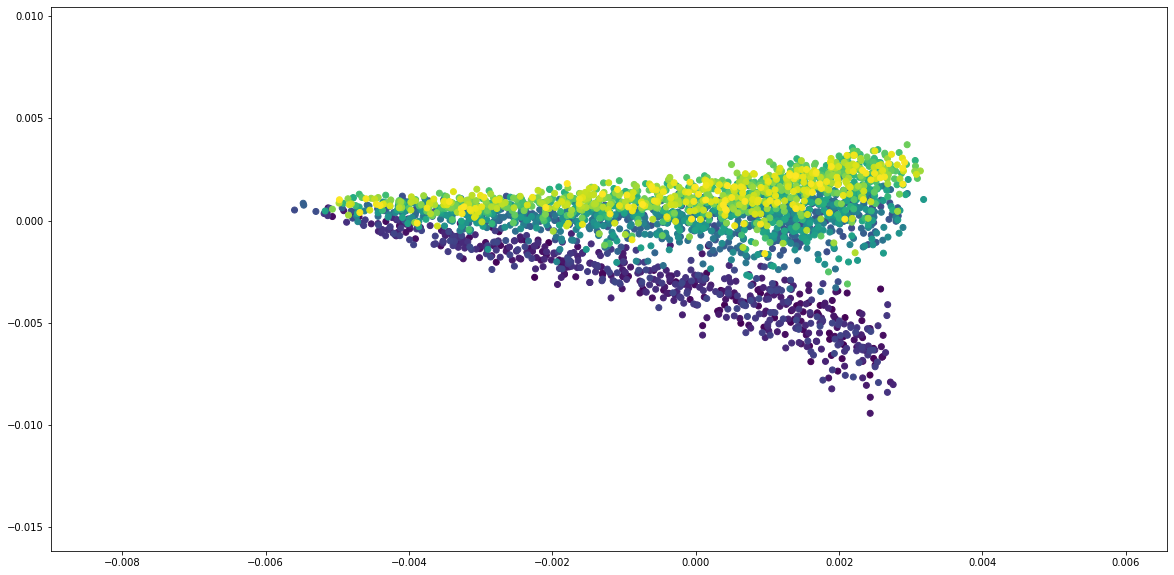

In [11]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(diffu[:,1], diffu[:,2], c=np.arange(rna.shape[0]))

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
dataset = scDataset(standardize=False)

In [13]:
diff_sim_atac = torch.FloatTensor(np.log1p(diff_sim_atac) * 2).to(device)
diff_sim_rna = torch.FloatTensor(np.log1p(diff_sim_rna) * 2).to(device)

In [32]:
def dist_loss(recon_atac, recon_rna, atac, rna, z, diff_atac, diff_rna, lamb):
    loss_recon_rna = F.mse_loss(rna, recon_rna)
#     loss_recon_atac = F.mse_loss(atac, recon_atac)
#     loss_dist_atac = lamb * F.mse_loss(diff_atac.reshape(-1), pairwise_distance(z).reshape(-1))
#     loss_dist_rna = lamb * F.mse_loss(diff_rna.reshape(-1), pairwise_distance(z).reshape(-1))
    loss_recon_atac=0
    loss_dist_atac=0
    loss_dist_rna=0
    loss = loss_recon_rna + loss_recon_atac + loss_dist_atac + loss_dist_rna
    return loss, loss_recon_rna, loss_recon_atac,  loss_dist_atac,  loss_dist_rna

In [42]:
def train(model):
    model.train()

    total_loss = 0
    total_loss_recon_rna = total_loss_recon_atac = 0
    total_loss_dist_atac = total_loss_dist_rna = 0
    for data in data_loader:
        optimizer.zero_grad()
        batch_atac = data['ATAC'].to(device)
        batch_rna = data['RNA'].to(device)
        recon_atac, recon_rna, z = model(batch_atac, batch_rna)
        print(recon_rna)
        print(batch_rna)
        print(z)
        
        batch_diff_atac = diff_sim_atac[data['index'], :][:, data['index']]
        batch_diff_rna = diff_sim_rna[data['index'], :][:, data['index']]
        loss = dist_loss(recon_atac, recon_rna, batch_atac, batch_rna, z, batch_diff_atac, batch_diff_rna, lamb=1)
        total_loss += loss[0]
        total_loss_recon_rna += loss[1]
        total_loss_recon_atac += loss[2]
        total_loss_dist_rna += loss[3]
        total_loss_dist_atac += loss[4]
        current_loss = loss[0]
        current_loss.backward(retain_graph=False)
        optimizer.step()
    
    return total_loss.item() / len(dataset), total_loss_recon_rna.item() / len(dataset), total_loss_recon_atac/ len(dataset), \
 total_loss_dist_rna / len(dataset), total_loss_dist_atac / len(dataset)

In [43]:
def test(model):
#     model.test()
    atac_lsi = latent_semantic_indexing(atac, k=1000)
    _, _, z = model(torch.FloatTensor(atac_lsi).to(device), torch.FloatTensor(rna).to(device))
    z = z.detach().cpu().numpy()
    return z

In [51]:
data_loader = DataLoader(dataset, shuffle=True, batch_size=32)
for data in data_loader:
    print(data)

{'ATAC': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'RNA': tensor([[0.0000, 0.0000, 0.0000,  ..., 2.7654, 0.0000, 0.0000],
        [0.0000, 1.5605, 1.9836,  ..., 1.7943, 1.9836, 0.8126],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.5243],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 2.2869, 1.3732, 0.0000]]), 'index': tensor([ 450, 1416, 2020, 1703, 1599, 2053, 2219,  228, 2347, 1436,  661, 1804,
         573, 1676, 2465, 1667,  762,  701,  830, 2095, 1040,  915,  846, 1287,
         154, 2212, 1234, 2108,  384, 1156,  800,  392])}
{'ATAC': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0

        1766,  968,  890, 1876, 1952, 2074, 1558,  325])}
{'ATAC': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'RNA': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.9369,  ..., 0.0000, 2.1879, 0.0000],
        ...,
        [0.0000, 0.0000, 2.5472,  ..., 1.3719, 1.9295, 1.9295],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 2.0938,  ..., 0.0000, 0.0000, 0.0000]]), 'index': tensor([1211,  501, 1542, 1728,  315, 2237,  151,  341, 1685, 1133,  477, 1290,
         365, 1043, 2483,  938,  851,   61,  713,  919,    9, 2560,  748, 1336,
        1080, 1213,   49, 2087,  988,  729,   66, 1456])}
{'ATAC': tensor([[0., 0., 0.,  ..., 0., 0., 0

        2253, 2026,  269, 1370, 1161, 1342, 1373, 1560])}
{'ATAC': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'RNA': tensor([[0.0000, 0.7972, 0.7972,  ..., 0.0000, 1.5386, 0.0000],
        [0.0000, 0.8832, 0.0000,  ..., 0.0000, 0.0000, 0.8832],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.4407, 2.0079, 2.3675,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.2754,  ..., 0.0000, 1.2754, 0.0000]]), 'index': tensor([2610,  725, 2177, 2378, 2019, 1966, 2174,  903, 1744, 1168, 1701, 1200,
        2506, 1925,  877,  850,  822, 2638, 1003, 1297, 1048, 1519,  420,  773,
         329, 1500, 1074, 1443,  155, 1314, 2169, 2415])}
{'ATAC': tensor([[0., 0., 0.,  ..., 0., 0., 0

         369, 1396,  998, 2521, 2448, 1134, 1524, 2034])}
{'ATAC': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.9587]]), 'RNA': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.8447],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.7584, 1.8982, 0.0000,  ..., 0.0000, 1.4826, 0.7584],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]), 'index': tensor([1678, 1671, 1140, 1096,  755,   41,  949,  787,  869,  338, 1854,  739,
         782, 1505, 1810, 2071,  406, 2

        1276,  487,  591, 1607, 2208,  881, 1320,  326])}
{'ATAC': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'RNA': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.7784, 0.0000,  ..., 0.0000, 2.2193, 0.9708],
        [0.0000, 2.4228, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 2.1344, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.5622, 0.0000],
        [0.0000, 0.0000, 2.2504,  ..., 1.3430, 1.3430, 0.0000]]), 'index': tensor([1226, 1065,  760, 1009,  254, 2086, 1917, 1695, 1835, 1469,  446,  964,
         273,  772, 1206, 1773,  897, 1177, 1907, 1090, 1997, 1582,  110, 1144,
         225, 2609, 1167, 1801, 1567, 1748, 2332,  813])}
{'ATAC': tensor([[0., 0., 0.,  ..., 0., 0., 0

         209, 1608, 1166, 1294, 1551, 1323, 1706,  102])}
{'ATAC': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'RNA': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.8436, 0.0000, 1.2973,  ..., 0.0000, 0.0000, 1.2973],
        [0.0000, 1.1616, 1.1616,  ..., 1.1616, 0.0000, 0.0000],
        [0.0000, 0.0000, 2.2589,  ..., 0.0000, 0.0000, 0.0000]]), 'index': tensor([1339, 2105, 2023, 2117, 1882, 1535,  125, 1354, 1571, 1853,  286,  265,
        1102, 2436,  944, 1688, 2240, 1989,  202,  374, 1237, 2187,  921, 2409,
         249, 1260, 2178, 1014,  462, 2596, 1837, 1724])}
{'ATAC': tensor([[0.0000, 0.0000, 0.0000,  ..

        2090, 1477,  156, 2120, 1171,  538, 1251, 1627])}
{'ATAC': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'RNA': tensor([[0.0000, 2.2134, 1.8611,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 2.0652,  ..., 3.0755, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 3.4705,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 2.6967,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]), 'index': tensor([1750, 1034,  108, 2327, 1481, 2100, 2567, 2441, 1879,   50,  932,  688,
        2138, 1707, 1265, 2453,  746,  678, 1365, 2046,  843,  236,  824, 1715,
           8, 2501,  983, 1614, 1538, 1092, 2395, 1955])}
{'ATAC': tensor([[0., 0., 0.,  ..., 0., 0., 0

        1349, 2636, 1858,  990, 2349, 1117,  608,  909])}
{'ATAC': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'RNA': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.1445, 1.1445,  ..., 2.0045, 0.0000, 0.0000],
        [0.0000, 1.6463, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 1.2914,  ..., 0.0000, 1.2914, 1.8367],
        [0.0000, 0.0000, 2.4181,  ..., 1.2687, 2.1597, 1.2687],
        [0.0000, 0.8639, 0.0000,  ..., 0.0000, 0.8639, 0.0000]]), 'index': tensor([1890,  516, 1936, 1051, 1311,  970, 2589,  333,  486, 2151, 1880, 1960,
        2182, 2568, 1665, 1136, 2040,  348,  287, 1487,  992,  504, 2475, 2027,
         930,  542,  778, 2423,  966, 2008, 2478,   81])}
{'ATAC': tensor([[0., 0., 0.,  ..., 0., 0., 0

        1803,  334,  403,  480,  563, 1959, 1157,  382])}
{'ATAC': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'RNA': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.4612, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.2336, 2.1164],
        [0.0000, 0.0000, 1.8185,  ..., 0.0000, 1.8185, 0.0000],
        ...,
        [1.2885, 0.0000, 0.8389,  ..., 0.0000, 0.8389, 0.0000],
        [0.0000, 2.1734, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.8440, 0.0000]]), 'index': tensor([2406, 2094, 1217, 1333,  758, 1019, 1800,  769, 1123, 2213,  271, 1083,
        1598, 2375, 2302,  127, 1097, 1225, 1195, 1872, 1772, 2189, 1716, 1746,
        2583,  614, 2152,  697,   26, 1351, 1642,  176])}
{'ATAC': tensor([[0., 0., 0.,  ..., 0., 0., 0

## AutoEncoder

In [44]:
data_loader = DataLoader(dataset, shuffle=True, batch_size=32)

model_ae = AutoEncoder(in_channels_atac=1000, in_channels_rna=rna.shape[1], latent_channels_atac=8, latent_channels_rna=8, latent_channels_z=2).to(device)
optimizer = torch.optim.Adam(model_ae.parameters(), lr=1e-4, weight_decay=0.01)

for epoch in range(0, 3):

    loss, l1, l2, l3, l4 = train(model_ae)
    if epoch % 10 == 0:
        print("Epoch: ", epoch, "Total loss:", loss, "Recon RNA loss: ", l1, "Recon ATAC loss: ", l2, "Dist RNA loss: ", l3, "Dist ATAC loss", l4)

tensor([[ 8.8520e-05, -9.0852e-02, -2.2876e-02,  ...,  8.0564e-02,
          3.3942e-02, -1.1895e-01],
        [ 1.6141e-04, -9.2142e-02, -2.3826e-02,  ...,  8.0903e-02,
          3.5089e-02, -1.2004e-01],
        [-4.0028e-04, -9.2327e-02, -2.3241e-02,  ...,  8.0669e-02,
          3.4798e-02, -1.1983e-01],
        ...,
        [ 4.8787e-04, -9.1210e-02, -2.3618e-02,  ...,  8.0845e-02,
          3.4561e-02, -1.1949e-01],
        [-1.2062e-04, -9.1754e-02, -2.3212e-02,  ...,  8.0672e-02,
          3.4537e-02, -1.1954e-01],
        [ 1.0954e-04, -9.1092e-02, -2.3062e-02,  ...,  8.0630e-02,
          3.4161e-02, -1.1916e-01]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197,  1.4967,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554,  2.4739],
        [-0.2093, -0.4197,  1.7254,  ...,  3.0267, -0.5554, -0.3166],
        ...,
        [-0.2093, -0.4197,  0.5229,  ..., -0.3284,  1.5177,  2.6109],
        [-0.2093, -0.4197,  0.906

        [-0.1467, -0.0462]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-6.9767e-05, -9.0588e-02, -2.1860e-02,  ...,  7.9429e-02,
          3.3240e-02, -1.1701e-01],
        [-4.6628e-04, -9.0614e-02, -2.1378e-02,  ...,  7.9238e-02,
          3.2947e-02, -1.1679e-01],
        [-1.0106e-03, -9.1085e-02, -2.1007e-02,  ...,  7.9080e-02,
          3.2915e-02, -1.1682e-01],
        ...,
        [-1.1046e-03, -9.1393e-02, -2.1094e-02,  ...,  7.9107e-02,
          3.3101e-02, -1.1701e-01],
        [-1.3725e-04, -9.0646e-02, -2.1814e-02,  ...,  7.9410e-02,
          3.3235e-02, -1.1702e-01],
        [ 2.7950e-04, -9.0273e-02, -2.2090e-02,  ...,  7.9528e-02,
          3.3250e-02, -1.1698e-01]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093,  3.5192,  0.2222,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  1.2594,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284,  1.4217, -0.3166],
        ...,
        [-0.2093, -0.4197, -0.05

       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093,  1.2074,  1.1801,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  0.6647,  ..., -0.3284,  1.7371, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284,  2.7018, -0.3166],
        ...,
        [-0.2093, -0.4197,  1.8330,  ..., -0.3284,  1.8583, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ...,  1.6763,  0.9937, -0.3166]],
       device='cuda:0')
tensor([[-0.1427, -0.0460],
        [-0.1500, -0.0415],
        [-0.1497, -0.0459],
        [-0.1456, -0.0390],
        [-0.1484, -0.0422],
        [-0.1475, -0.0413],
        [-0.1509, -0.0444],
        [-0.1452, -0.0361],
        [-0.1477, -0.0460],
        [-0.1490, -0.0351],
        [-0.1423, -0.0401],
        [-0.1453, -0.0354],
        [-0.1515, -0.0364],
        [-0.1496, -0.0396],
        [-0.1442, -0.0457],
        [-0.1511, -0.0393],
        [-0.1489, -0.0407],
        [-0.1444,

        [-0.1450, -0.0415]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0017, -0.0868, -0.0174,  ...,  0.0768,  0.0310, -0.1123],
        [-0.0027, -0.0872, -0.0165,  ...,  0.0764,  0.0306, -0.1120],
        [-0.0019, -0.0869, -0.0173,  ...,  0.0768,  0.0310, -0.1123],
        ...,
        [-0.0020, -0.0869, -0.0172,  ...,  0.0767,  0.0309, -0.1122],
        [-0.0023, -0.0873, -0.0170,  ...,  0.0766,  0.0310, -0.1123],
        [-0.0025, -0.0865, -0.0163,  ...,  0.0764,  0.0302, -0.1116]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093,  4.1894,  1.9215,  ..., -0.3284,  3.0325, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284,  2.4826, -0.3166],
        ...,
        [-0.2093,  3.9129, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093,  2.4479, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093,  1.2106, -0.8166,  ..., -0.3284, -0.5554, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1405, -0.0566],
        [-0.1451, -0.0453],
        [-0.1448, -0.0459],
        [-0.1436, -0.0412],
        [-0.1442, -0.0430],
        [-0.1446, -0.0422],
        [-0.1377, -0.0398],
        [-0.1492, -0.0475],
        [-0.1426, -0.0366],
        [-0.1418, -0.0429],
        [-0.1474, -0.0474],
        [-0.1486, -0.0437],
        [-0.1456, -0.0444],
        [-0.1391, -0.0474],
        [-0.1454, -0.0463],
        [-0.1404, -0.0414],
        [-0.1427, -0.0404],
        [-0.1471, -0.0437],
        [-0.1430, -0.0477],
        [-0.1369, -0.0418],
        [-0.1441, -0.0505],
        [-0.1439, -0.0458],
        [-0.1408, -0.0362],
        [-0.1424, -0.0501],
        [-0.1427, -0.0439],
        [-0.1444, -0.0423],
        [-0.1443, -0.0476],
        [-0.1405, -0.0480],
        [-0.1434, -0.0469],
        [-0.1456, -0.0536],
        [-0.1425, -0.0491],
        [-0.1461, -0.0490]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0033, -0.0846, -0.0149,  

        [-0.1424, -0.0462]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0035, -0.0831, -0.0142,  ...,  0.0739,  0.0300, -0.1081],
        [-0.0040, -0.0833, -0.0138,  ...,  0.0737,  0.0298, -0.1080],
        [-0.0041, -0.0833, -0.0137,  ...,  0.0736,  0.0297, -0.1079],
        ...,
        [-0.0035, -0.0825, -0.0138,  ...,  0.0737,  0.0295, -0.1076],
        [-0.0036, -0.0827, -0.0139,  ...,  0.0737,  0.0296, -0.1078],
        [-0.0039, -0.0831, -0.0137,  ...,  0.0736,  0.0296, -0.1078]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197, -0.8166,  ...,  1.5161, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  2.3952,  ...,  4.2748, -0.5554, -0.3166],
        ...,
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093,  2.6046, -0.8166,  ..., -0.3284,  1.5908, -0.3166],
        [-0.2093, -0.4197,  0.0286,  ..., -0.3284,  1.4034, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1345, -0.0407],
        [-0.1379, -0.0546],
        [-0.1412, -0.0469],
        [-0.1415, -0.0496],
        [-0.1393, -0.0490],
        [-0.1448, -0.0547],
        [-0.1424, -0.0501],
        [-0.1431, -0.0573],
        [-0.1364, -0.0520],
        [-0.1376, -0.0489],
        [-0.1415, -0.0477],
        [-0.1415, -0.0499],
        [-0.1368, -0.0446],
        [-0.1395, -0.0450],
        [-0.1396, -0.0497],
        [-0.1405, -0.0501],
        [-0.1396, -0.0434],
        [-0.1423, -0.0460],
        [-0.1353, -0.0507],
        [-0.1389, -0.0445],
        [-0.1383, -0.0547],
        [-0.1390, -0.0482],
        [-0.1318, -0.0549],
        [-0.1347, -0.0453],
        [-0.1426, -0.0472],
        [-0.1350, -0.0485],
        [-0.1382, -0.0403],
        [-0.1411, -0.0559],
        [-0.1413, -0.0553],
        [-0.1435, -0.0490],
        [-0.1438, -0.0475],
        [-0.1359, -0.0518]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0043, -0.0809, -0.0124,  

        [-0.1358, -0.0476]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0049, -0.0801, -0.0111,  ...,  0.0707,  0.0287, -0.1038],
        [-0.0060, -0.0801, -0.0098,  ...,  0.0700,  0.0279, -0.1032],
        [-0.0052, -0.0796, -0.0104,  ...,  0.0704,  0.0280, -0.1032],
        ...,
        [-0.0052, -0.0796, -0.0104,  ...,  0.0704,  0.0281, -0.1032],
        [-0.0057, -0.0797, -0.0099,  ...,  0.0701,  0.0278, -0.1030],
        [-0.0049, -0.0799, -0.0109,  ...,  0.0706,  0.0285, -0.1036]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  1.1053,  ..., -0.3284,  1.6260, -0.3166],
        [-0.2093,  2.7666, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        ...,
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093,  3.8943, -0.8166,  ..., -0.3284,  2.2675, -0.3166],
        [-0.2093,  2.6364,  1.1000,  ..., -0.3284, -0.5554, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1355, -0.0507],
        [-0.1366, -0.0583],
        [-0.1354, -0.0521],
        [-0.1357, -0.0510],
        [-0.1368, -0.0498],
        [-0.1346, -0.0479],
        [-0.1420, -0.0543],
        [-0.1345, -0.0529],
        [-0.1354, -0.0534],
        [-0.1392, -0.0493],
        [-0.1326, -0.0546],
        [-0.1377, -0.0546],
        [-0.1391, -0.0515],
        [-0.1357, -0.0541],
        [-0.1364, -0.0563],
        [-0.1370, -0.0542],
        [-0.1341, -0.0574],
        [-0.1315, -0.0570],
        [-0.1421, -0.0591],
        [-0.1402, -0.0506],
        [-0.1367, -0.0548],
        [-0.1368, -0.0537],
        [-0.1396, -0.0542],
        [-0.1372, -0.0551],
        [-0.1404, -0.0579],
        [-0.1297, -0.0603],
        [-0.1321, -0.0567],
        [-0.1352, -0.0550],
        [-0.1410, -0.0526],
        [-0.1356, -0.0511],
        [-0.1381, -0.0523],
        [-0.1382, -0.0522]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0057, -0.0779, -0.0087,  

        [-0.1348, -0.0555]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0063, -0.0768, -0.0069,  ...,  0.0668,  0.0264, -0.0991],
        [-0.0067, -0.0770, -0.0067,  ...,  0.0667,  0.0264, -0.0991],
        [-0.0062, -0.0764, -0.0069,  ...,  0.0668,  0.0262, -0.0989],
        ...,
        [-0.0062, -0.0765, -0.0068,  ...,  0.0668,  0.0263, -0.0989],
        [-0.0059, -0.0763, -0.0071,  ...,  0.0670,  0.0264, -0.0990],
        [-0.0064, -0.0768, -0.0068,  ...,  0.0668,  0.0264, -0.0990]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197,  0.6524,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284,  0.9749, -0.3166],
        ...,
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554,  5.6756],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  0.2118,  ..., -0.3284, -0.5554, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1310, -0.0594],
        [-0.1385, -0.0567],
        [-0.1367, -0.0550],
        [-0.1358, -0.0547],
        [-0.1343, -0.0551],
        [-0.1300, -0.0545],
        [-0.1298, -0.0543],
        [-0.1288, -0.0568],
        [-0.1344, -0.0555],
        [-0.1349, -0.0547],
        [-0.1322, -0.0567],
        [-0.1331, -0.0596],
        [-0.1324, -0.0576],
        [-0.1293, -0.0537],
        [-0.1353, -0.0573],
        [-0.1286, -0.0576],
        [-0.1289, -0.0526],
        [-0.1300, -0.0541],
        [-0.1336, -0.0531],
        [-0.1371, -0.0594],
        [-0.1355, -0.0565],
        [-0.1282, -0.0552],
        [-0.1305, -0.0531],
        [-0.1315, -0.0569],
        [-0.1300, -0.0576],
        [-0.1321, -0.0535],
        [-0.1364, -0.0553],
        [-0.1368, -0.0598],
        [-0.1381, -0.0581],
        [-0.1367, -0.0578],
        [-0.1283, -0.0560],
        [-0.1308, -0.0571]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0064, -0.0750, -0.0049,  

        [-0.1319, -0.0573]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0060, -0.0746, -0.0046,  ...,  0.0640,  0.0246, -0.0946],
        [-0.0062, -0.0745, -0.0044,  ...,  0.0639,  0.0244, -0.0945],
        [-0.0064, -0.0747, -0.0042,  ...,  0.0638,  0.0244, -0.0944],
        ...,
        [-0.0063, -0.0747, -0.0044,  ...,  0.0639,  0.0245, -0.0946],
        [-0.0064, -0.0750, -0.0044,  ...,  0.0639,  0.0247, -0.0947],
        [-0.0065, -0.0747, -0.0042,  ...,  0.0638,  0.0244, -0.0945]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  0.7066,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        ...,
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284,  1.7801, -0.3166],
        [-0.2093, -0.4197,  1.0630,  ..., -0.3284,  1.5671, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1334, -0.0611],
        [-0.1312, -0.0561],
        [-0.1318, -0.0598],
        [-0.1296, -0.0537],
        [-0.1336, -0.0624],
        [-0.1294, -0.0604],
        [-0.1306, -0.0554],
        [-0.1316, -0.0562],
        [-0.1298, -0.0598],
        [-0.1296, -0.0581],
        [-0.1313, -0.0586],
        [-0.1295, -0.0559],
        [-0.1292, -0.0631],
        [-0.1306, -0.0556],
        [-0.1307, -0.0606],
        [-0.1338, -0.0621],
        [-0.1281, -0.0605],
        [-0.1295, -0.0544],
        [-0.1288, -0.0546],
        [-0.1349, -0.0581],
        [-0.1302, -0.0577],
        [-0.1313, -0.0572],
        [-0.1315, -0.0609],
        [-0.1326, -0.0569],
        [-0.1315, -0.0587],
        [-0.1271, -0.0611],
        [-0.1316, -0.0589],
        [-0.1312, -0.0540],
        [-0.1311, -0.0636],
        [-0.1329, -0.0600],
        [-0.1332, -0.0622],
        [-0.1359, -0.0586]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0066, -0.0731, -0.0025,  

        [-0.1289, -0.0643]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0066, -0.0717, -0.0015,  ...,  0.0609,  0.0227, -0.0907],
        [-0.0064, -0.0717, -0.0017,  ...,  0.0610,  0.0228, -0.0907],
        [-0.0064, -0.0717, -0.0017,  ...,  0.0610,  0.0228, -0.0907],
        ...,
        [-0.0067, -0.0716, -0.0013,  ...,  0.0608,  0.0225, -0.0905],
        [-0.0065, -0.0716, -0.0016,  ...,  0.0609,  0.0227, -0.0906],
        [-0.0064, -0.0717, -0.0017,  ...,  0.0610,  0.0228, -0.0907]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093,  3.1158,  0.5712,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ...,  3.9807, -0.5554, -0.3166],
        ...,
        [-0.2093, -0.4197,  1.3250,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  1.5140,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  1.7240,  ..., -0.3284,  2.5139, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1273, -0.0573],
        [-0.1258, -0.0592],
        [-0.1328, -0.0618],
        [-0.1306, -0.0630],
        [-0.1278, -0.0633],
        [-0.1310, -0.0565],
        [-0.1317, -0.0635],
        [-0.1292, -0.0652],
        [-0.1277, -0.0581],
        [-0.1306, -0.0613],
        [-0.1290, -0.0603],
        [-0.1283, -0.0625],
        [-0.1313, -0.0629],
        [-0.1273, -0.0598],
        [-0.1301, -0.0616],
        [-0.1281, -0.0612],
        [-0.1313, -0.0673],
        [-0.1285, -0.0595],
        [-0.1283, -0.0644],
        [-0.1327, -0.0638],
        [-0.1284, -0.0579],
        [-0.1319, -0.0620],
        [-0.1281, -0.0625],
        [-0.1273, -0.0617],
        [-0.1283, -0.0611],
        [-0.1311, -0.0642],
        [-0.1287, -0.0591],
        [-0.1321, -0.0617],
        [-0.1309, -0.0605],
        [-0.1278, -0.0587],
        [-0.1260, -0.0593],
        [-0.1289, -0.0605]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-6.5329e-03, -7.0452e-02,  7

        [-0.1289, -0.0630]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0063, -0.0689,  0.0015,  ...,  0.0584,  0.0208, -0.0884],
        [-0.0064, -0.0689,  0.0017,  ...,  0.0583,  0.0207, -0.0883],
        [-0.0065, -0.0691,  0.0017,  ...,  0.0583,  0.0208, -0.0884],
        ...,
        [-0.0064, -0.0690,  0.0016,  ...,  0.0584,  0.0208, -0.0884],
        [-0.0064, -0.0690,  0.0017,  ...,  0.0583,  0.0207, -0.0883],
        [-0.0063, -0.0689,  0.0016,  ...,  0.0584,  0.0207, -0.0884]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  1.1299,  ..., -0.3284,  1.6603, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        ...,
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554,  4.3008],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  2.2147,  ..., -0.3284, -0.5554,  2.3936]],
       devic

       device='cuda:0')
tensor([[-0.1263, -0.0633],
        [-0.1256, -0.0599],
        [-0.1277, -0.0665],
        [-0.1280, -0.0642],
        [-0.1291, -0.0643],
        [-0.1286, -0.0627],
        [-0.1264, -0.0598],
        [-0.1244, -0.0623],
        [-0.1271, -0.0625],
        [-0.1304, -0.0655],
        [-0.1286, -0.0643],
        [-0.1273, -0.0626],
        [-0.1247, -0.0617],
        [-0.1252, -0.0653],
        [-0.1255, -0.0597],
        [-0.1270, -0.0608],
        [-0.1244, -0.0578],
        [-0.1263, -0.0611],
        [-0.1284, -0.0629],
        [-0.1272, -0.0624],
        [-0.1300, -0.0666],
        [-0.1261, -0.0589],
        [-0.1281, -0.0622],
        [-0.1281, -0.0624],
        [-0.1287, -0.0617],
        [-0.1278, -0.0653],
        [-0.1283, -0.0647],
        [-0.1254, -0.0624],
        [-0.1265, -0.0617],
        [-0.1253, -0.0613],
        [-0.1270, -0.0640],
        [-0.1280, -0.0641]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0067, -0.0674,  0.0033,  

        [-0.1256, -0.0650]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0067, -0.0668,  0.0041,  ...,  0.0558,  0.0191, -0.0862],
        [-0.0067, -0.0668,  0.0041,  ...,  0.0558,  0.0190, -0.0862],
        [-0.0069, -0.0668,  0.0043,  ...,  0.0557,  0.0189, -0.0861],
        ...,
        [-0.0066, -0.0667,  0.0041,  ...,  0.0558,  0.0190, -0.0861],
        [-0.0065, -0.0665,  0.0041,  ...,  0.0558,  0.0189, -0.0861],
        [-0.0068, -0.0667,  0.0042,  ...,  0.0557,  0.0189, -0.0861]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  0.4750,  ..., -0.3284,  1.4435, -0.3166],
        ...,
        [-0.2093,  2.0753, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  1.3972,  ..., -0.3284, -0.5554, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1258, -0.0670],
        [-0.1234, -0.0637],
        [-0.1285, -0.0649],
        [-0.1242, -0.0622],
        [-0.1273, -0.0653],
        [-0.1275, -0.0637],
        [-0.1262, -0.0660],
        [-0.1272, -0.0643],
        [-0.1264, -0.0644],
        [-0.1238, -0.0631],
        [-0.1245, -0.0661],
        [-0.1264, -0.0654],
        [-0.1249, -0.0633],
        [-0.1233, -0.0635],
        [-0.1259, -0.0603],
        [-0.1257, -0.0630],
        [-0.1254, -0.0641],
        [-0.1274, -0.0634],
        [-0.1251, -0.0634],
        [-0.1253, -0.0619],
        [-0.1249, -0.0648],
        [-0.1259, -0.0655],
        [-0.1239, -0.0651],
        [-0.1265, -0.0644],
        [-0.1248, -0.0641],
        [-0.1268, -0.0644],
        [-0.1233, -0.0653],
        [-0.1255, -0.0655],
        [-0.1260, -0.0647],
        [-0.1249, -0.0608],
        [-0.1257, -0.0660],
        [-0.1250, -0.0619]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0070, -0.0658,  0.0050,  

        [-0.1261, -0.0640]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0070, -0.0650,  0.0056,  ...,  0.0532,  0.0183, -0.0842],
        [-0.0070, -0.0650,  0.0055,  ...,  0.0532,  0.0183, -0.0842],
        [-0.0070, -0.0650,  0.0055,  ...,  0.0532,  0.0183, -0.0842],
        ...,
        [-0.0069, -0.0651,  0.0054,  ...,  0.0533,  0.0184, -0.0843],
        [-0.0069, -0.0649,  0.0055,  ...,  0.0532,  0.0182, -0.0842],
        [-0.0071, -0.0650,  0.0057,  ...,  0.0531,  0.0182, -0.0842]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093,  1.7231, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284,  1.1886, -0.3166],
        ...,
        [-0.2093, -0.4197,  0.8486,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284,  2.1325, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284,  2.8484, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1219, -0.0668],
        [-0.1242, -0.0661],
        [-0.1242, -0.0639],
        [-0.1259, -0.0682],
        [-0.1260, -0.0663],
        [-0.1265, -0.0653],
        [-0.1223, -0.0632],
        [-0.1238, -0.0644],
        [-0.1240, -0.0655],
        [-0.1240, -0.0617],
        [-0.1235, -0.0646],
        [-0.1249, -0.0656],
        [-0.1236, -0.0669],
        [-0.1229, -0.0655],
        [-0.1265, -0.0660],
        [-0.1254, -0.0639],
        [-0.1246, -0.0659],
        [-0.1236, -0.0634],
        [-0.1226, -0.0649],
        [-0.1245, -0.0668],
        [-0.1256, -0.0660],
        [-0.1247, -0.0637],
        [-0.1240, -0.0634],
        [-0.1234, -0.0639],
        [-0.1234, -0.0662],
        [-0.1239, -0.0642],
        [-0.1239, -0.0611],
        [-0.1233, -0.0623],
        [-0.1246, -0.0646],
        [-0.1265, -0.0661],
        [-0.1249, -0.0624],
        [-0.1256, -0.0635]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0070, -0.0643,  0.0060,  

        [-0.1235, -0.0641]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0072, -0.0643,  0.0063,  ...,  0.0511,  0.0182, -0.0824],
        [-0.0070, -0.0641,  0.0062,  ...,  0.0512,  0.0181, -0.0824],
        [-0.0071, -0.0643,  0.0061,  ...,  0.0512,  0.0182, -0.0825],
        ...,
        [-0.0074, -0.0643,  0.0064,  ...,  0.0510,  0.0181, -0.0824],
        [-0.0074, -0.0643,  0.0064,  ...,  0.0510,  0.0180, -0.0823],
        [-0.0071, -0.0642,  0.0062,  ...,  0.0511,  0.0181, -0.0824]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197,  0.8021,  ..., -0.3284, -0.5554, -0.3166],
        [ 4.2624, -0.4197,  1.0195,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        ...,
        [-0.2093, -0.4197,  1.0659,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093,  1.2074,  1.1801,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284,  1.8170, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1231, -0.0664],
        [-0.1240, -0.0637],
        [-0.1229, -0.0644],
        [-0.1230, -0.0656],
        [-0.1271, -0.0644],
        [-0.1222, -0.0667],
        [-0.1255, -0.0633],
        [-0.1230, -0.0652],
        [-0.1229, -0.0627],
        [-0.1241, -0.0662],
        [-0.1241, -0.0658],
        [-0.1232, -0.0646],
        [-0.1240, -0.0630],
        [-0.1251, -0.0646],
        [-0.1259, -0.0650],
        [-0.1231, -0.0640],
        [-0.1240, -0.0635],
        [-0.1216, -0.0640],
        [-0.1218, -0.0662],
        [-0.1238, -0.0638],
        [-0.1231, -0.0643],
        [-0.1222, -0.0657],
        [-0.1243, -0.0640],
        [-0.1219, -0.0630],
        [-0.1229, -0.0617],
        [-0.1234, -0.0619],
        [-0.1231, -0.0645],
        [-0.1221, -0.0659],
        [-0.1231, -0.0654],
        [-0.1233, -0.0655],
        [-0.1207, -0.0644],
        [-0.1239, -0.0656]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0076, -0.0635,  0.0069,  

        [-0.1228, -0.0662]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0079, -0.0631,  0.0074,  ...,  0.0495,  0.0181, -0.0804],
        [-0.0079, -0.0631,  0.0075,  ...,  0.0494,  0.0181, -0.0804],
        [-0.0080, -0.0631,  0.0076,  ...,  0.0494,  0.0180, -0.0804],
        ...,
        [-0.0080, -0.0630,  0.0076,  ...,  0.0494,  0.0180, -0.0803],
        [-0.0080, -0.0631,  0.0075,  ...,  0.0494,  0.0181, -0.0804],
        [-0.0080, -0.0630,  0.0076,  ...,  0.0494,  0.0179, -0.0803]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [ 3.3297,  2.2951,  1.4252,  ...,  2.1039, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284,  1.5708, -0.3166],
        ...,
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284,  2.4888, -0.3166],
        [-0.2093, -0.4197,  0.8518,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093,  1.8333, -0.8166,  ..., -0.3284, -0.5554, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1220, -0.0654],
        [-0.1213, -0.0647],
        [-0.1234, -0.0667],
        [-0.1199, -0.0646],
        [-0.1219, -0.0660],
        [-0.1218, -0.0646],
        [-0.1239, -0.0678],
        [-0.1228, -0.0666],
        [-0.1233, -0.0669],
        [-0.1221, -0.0638],
        [-0.1224, -0.0657],
        [-0.1217, -0.0641],
        [-0.1247, -0.0669],
        [-0.1214, -0.0666],
        [-0.1213, -0.0643],
        [-0.1229, -0.0652],
        [-0.1224, -0.0661],
        [-0.1221, -0.0662],
        [-0.1214, -0.0671],
        [-0.1224, -0.0654],
        [-0.1223, -0.0666],
        [-0.1216, -0.0616],
        [-0.1220, -0.0635],
        [-0.1246, -0.0671],
        [-0.1217, -0.0637],
        [-0.1226, -0.0663],
        [-0.1213, -0.0659],
        [-0.1232, -0.0664],
        [-0.1243, -0.0656],
        [-0.1210, -0.0636],
        [-0.1231, -0.0659],
        [-0.1206, -0.0646]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0081, -0.0627,  0.0085,  

        [-0.1218, -0.0646]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0078, -0.0618,  0.0093,  ...,  0.0478,  0.0170, -0.0787],
        [-0.0078, -0.0619,  0.0092,  ...,  0.0479,  0.0171, -0.0788],
        [-0.0076, -0.0618,  0.0091,  ...,  0.0479,  0.0171, -0.0788],
        ...,
        [-0.0078, -0.0619,  0.0092,  ...,  0.0479,  0.0171, -0.0788],
        [-0.0078, -0.0619,  0.0093,  ...,  0.0478,  0.0170, -0.0788],
        [-0.0077, -0.0618,  0.0091,  ...,  0.0479,  0.0171, -0.0788]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197,  1.1875,  ..., -0.3284, -0.5554,  2.9263],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554,  2.3454],
        ...,
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284,  2.9328, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1215, -0.0657],
        [-0.1195, -0.0651],
        [-0.1219, -0.0686],
        [-0.1206, -0.0662],
        [-0.1208, -0.0655],
        [-0.1220, -0.0679],
        [-0.1225, -0.0660],
        [-0.1226, -0.0670],
        [-0.1206, -0.0659],
        [-0.1209, -0.0674],
        [-0.1221, -0.0659],
        [-0.1209, -0.0658],
        [-0.1207, -0.0672],
        [-0.1221, -0.0659],
        [-0.1205, -0.0667],
        [-0.1224, -0.0664],
        [-0.1220, -0.0640],
        [-0.1216, -0.0680],
        [-0.1223, -0.0669],
        [-0.1217, -0.0664],
        [-0.1207, -0.0659],
        [-0.1202, -0.0642],
        [-0.1207, -0.0646],
        [-0.1218, -0.0663],
        [-0.1206, -0.0665],
        [-0.1236, -0.0662],
        [-0.1205, -0.0655],
        [-0.1194, -0.0660],
        [-0.1211, -0.0677],
        [-0.1217, -0.0662],
        [-0.1228, -0.0664],
        [-0.1195, -0.0643]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0076, -0.0607,  0.0102,  

        [-0.1195, -0.0676]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0072, -0.0597,  0.0105,  ...,  0.0465,  0.0164, -0.0770],
        [-0.0073, -0.0597,  0.0107,  ...,  0.0464,  0.0163, -0.0770],
        [-0.0073, -0.0597,  0.0107,  ...,  0.0464,  0.0163, -0.0770],
        ...,
        [-0.0072, -0.0597,  0.0106,  ...,  0.0465,  0.0163, -0.0770],
        [-0.0073, -0.0597,  0.0107,  ...,  0.0464,  0.0163, -0.0770],
        [-0.0074, -0.0596,  0.0108,  ...,  0.0464,  0.0162, -0.0769]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197, -0.8166,  ..., -0.3284,  1.4936, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  1.2582,  ..., -0.3284, -0.5554, -0.3166],
        ...,
        [-0.2093, -0.4197,  1.9832,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284,  2.1310, -0.3166],
        [-0.2093,  1.2555,  0.2340,  ..., -0.3284, -0.5554, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1202, -0.0695],
        [-0.1205, -0.0665],
        [-0.1193, -0.0681],
        [-0.1200, -0.0679],
        [-0.1204, -0.0665],
        [-0.1204, -0.0675],
        [-0.1203, -0.0653],
        [-0.1180, -0.0678],
        [-0.1220, -0.0676],
        [-0.1203, -0.0682],
        [-0.1198, -0.0663],
        [-0.1203, -0.0666],
        [-0.1208, -0.0666],
        [-0.1208, -0.0664],
        [-0.1176, -0.0651],
        [-0.1218, -0.0678],
        [-0.1194, -0.0668],
        [-0.1220, -0.0687],
        [-0.1183, -0.0655],
        [-0.1203, -0.0661],
        [-0.1224, -0.0675],
        [-0.1213, -0.0654],
        [-0.1194, -0.0671],
        [-0.1218, -0.0679],
        [-0.1206, -0.0686],
        [-0.1200, -0.0685],
        [-0.1191, -0.0671],
        [-0.1209, -0.0673],
        [-0.1184, -0.0651],
        [-0.1199, -0.0670],
        [-0.1213, -0.0682],
        [-0.1198, -0.0684]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0072, -0.0584,  0.0110,  

        [-0.1191, -0.0659]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0070, -0.0572,  0.0112,  ...,  0.0445,  0.0155, -0.0752],
        [-0.0070, -0.0573,  0.0111,  ...,  0.0446,  0.0156, -0.0753],
        [-0.0069, -0.0572,  0.0111,  ...,  0.0446,  0.0155, -0.0752],
        ...,
        [-0.0070, -0.0572,  0.0111,  ...,  0.0446,  0.0155, -0.0752],
        [-0.0070, -0.0573,  0.0111,  ...,  0.0446,  0.0156, -0.0753],
        [-0.0070, -0.0572,  0.0111,  ...,  0.0446,  0.0155, -0.0752]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  0.8482,  ..., -0.3284,  2.0211, -0.3166],
        ...,
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554,  3.7706],
        [-0.2093, -0.4197,  0.2658,  ..., -0.3284, -0.5554, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1209, -0.0669],
        [-0.1199, -0.0675],
        [-0.1199, -0.0673],
        [-0.1197, -0.0675],
        [-0.1182, -0.0684],
        [-0.1206, -0.0662],
        [-0.1194, -0.0672],
        [-0.1208, -0.0688],
        [-0.1207, -0.0688],
        [-0.1197, -0.0680],
        [-0.1195, -0.0667],
        [-0.1206, -0.0678],
        [-0.1207, -0.0688],
        [-0.1195, -0.0673],
        [-0.1200, -0.0660],
        [-0.1204, -0.0680],
        [-0.1208, -0.0675],
        [-0.1211, -0.0669],
        [-0.1213, -0.0679],
        [-0.1201, -0.0673],
        [-0.1199, -0.0670],
        [-0.1209, -0.0671],
        [-0.1213, -0.0681],
        [-0.1174, -0.0685],
        [-0.1196, -0.0666],
        [-0.1207, -0.0683],
        [-0.1200, -0.0666],
        [-0.1201, -0.0670],
        [-0.1214, -0.0684],
        [-0.1205, -0.0664],
        [-0.1202, -0.0660],
        [-0.1209, -0.0689]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0070, -0.0563,  0.0111,  

        [-0.1198, -0.0670]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0071, -0.0553,  0.0111,  ...,  0.0426,  0.0151, -0.0737],
        [-0.0072, -0.0553,  0.0112,  ...,  0.0426,  0.0151, -0.0737],
        [-0.0072, -0.0552,  0.0112,  ...,  0.0426,  0.0150, -0.0737],
        ...,
        [-0.0072, -0.0553,  0.0111,  ...,  0.0426,  0.0151, -0.0737],
        [-0.0072, -0.0552,  0.0112,  ...,  0.0426,  0.0150, -0.0736],
        [-0.0072, -0.0553,  0.0111,  ...,  0.0426,  0.0151, -0.0737]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[ 3.7616, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        ...,
        [-0.2093, -0.4197,  1.2792,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093,  2.1482, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  0.7048,  ..., -0.3284, -0.5554, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1199, -0.0689],
        [-0.1201, -0.0681],
        [-0.1191, -0.0684],
        [-0.1186, -0.0654],
        [-0.1200, -0.0681],
        [-0.1199, -0.0683],
        [-0.1196, -0.0673],
        [-0.1196, -0.0672],
        [-0.1198, -0.0676],
        [-0.1210, -0.0674],
        [-0.1202, -0.0685],
        [-0.1191, -0.0670],
        [-0.1202, -0.0690],
        [-0.1207, -0.0682],
        [-0.1197, -0.0677],
        [-0.1205, -0.0682],
        [-0.1208, -0.0671],
        [-0.1194, -0.0668],
        [-0.1199, -0.0656],
        [-0.1207, -0.0670],
        [-0.1181, -0.0678],
        [-0.1198, -0.0668],
        [-0.1194, -0.0679],
        [-0.1196, -0.0685],
        [-0.1208, -0.0675],
        [-0.1191, -0.0677],
        [-0.1204, -0.0680],
        [-0.1209, -0.0686],
        [-0.1189, -0.0679],
        [-0.1188, -0.0681],
        [-0.1185, -0.0664],
        [-0.1198, -0.0663]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0071, -0.0541,  0.0112,  

        [-0.1186, -0.0685]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0072, -0.0536,  0.0113,  ...,  0.0416,  0.0144, -0.0713],
        [-0.0071, -0.0534,  0.0114,  ...,  0.0415,  0.0142, -0.0712],
        [-0.0072, -0.0535,  0.0114,  ...,  0.0415,  0.0143, -0.0712],
        ...,
        [-0.0073, -0.0535,  0.0115,  ...,  0.0415,  0.0142, -0.0712],
        [-0.0072, -0.0535,  0.0114,  ...,  0.0415,  0.0143, -0.0712],
        [-0.0072, -0.0536,  0.0114,  ...,  0.0415,  0.0143, -0.0712]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197,  1.3967,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        ...,
        [-0.2093, -0.4197,  1.9320,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  0.6154,  ...,  5.0521, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1188, -0.0678],
        [-0.1176, -0.0683],
        [-0.1182, -0.0669],
        [-0.1185, -0.0677],
        [-0.1195, -0.0684],
        [-0.1189, -0.0673],
        [-0.1187, -0.0691],
        [-0.1184, -0.0667],
        [-0.1190, -0.0679],
        [-0.1192, -0.0692],
        [-0.1182, -0.0674],
        [-0.1191, -0.0676],
        [-0.1188, -0.0677],
        [-0.1180, -0.0667],
        [-0.1175, -0.0680],
        [-0.1194, -0.0687],
        [-0.1175, -0.0674],
        [-0.1198, -0.0685],
        [-0.1178, -0.0667],
        [-0.1198, -0.0677],
        [-0.1182, -0.0694],
        [-0.1172, -0.0671],
        [-0.1182, -0.0674],
        [-0.1178, -0.0671],
        [-0.1187, -0.0672],
        [-0.1192, -0.0680],
        [-0.1183, -0.0669],
        [-0.1182, -0.0677],
        [-0.1183, -0.0681],
        [-0.1194, -0.0693],
        [-0.1169, -0.0666],
        [-0.1188, -0.0676]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0075, -0.0530,  0.0118,  

        [-0.1176, -0.0673]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0078, -0.0524,  0.0122,  ...,  0.0400,  0.0138, -0.0687],
        [-0.0077, -0.0524,  0.0121,  ...,  0.0400,  0.0138, -0.0687],
        [-0.0078, -0.0525,  0.0121,  ...,  0.0400,  0.0138, -0.0687],
        ...,
        [-0.0076, -0.0524,  0.0120,  ...,  0.0401,  0.0138, -0.0687],
        [-0.0077, -0.0524,  0.0121,  ...,  0.0400,  0.0138, -0.0687],
        [-0.0078, -0.0524,  0.0122,  ...,  0.0400,  0.0138, -0.0687]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093,  2.1510,  0.5085,  ..., -0.3284, -0.5554, -0.3166],
        [ 2.6591, -0.4197,  0.6177,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        ...,
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1166, -0.0660],
        [-0.1169, -0.0676],
        [-0.1172, -0.0681],
        [-0.1173, -0.0672],
        [-0.1175, -0.0669],
        [-0.1176, -0.0680],
        [-0.1166, -0.0667],
        [-0.1169, -0.0677],
        [-0.1178, -0.0669],
        [-0.1179, -0.0686],
        [-0.1175, -0.0673],
        [-0.1175, -0.0681],
        [-0.1173, -0.0671],
        [-0.1174, -0.0668],
        [-0.1165, -0.0681],
        [-0.1180, -0.0671],
        [-0.1163, -0.0675],
        [-0.1175, -0.0674],
        [-0.1181, -0.0676],
        [-0.1171, -0.0673],
        [-0.1184, -0.0676],
        [-0.1183, -0.0682],
        [-0.1164, -0.0668],
        [-0.1172, -0.0677],
        [-0.1172, -0.0678],
        [-0.1173, -0.0687],
        [-0.1182, -0.0687],
        [-0.1172, -0.0679],
        [-0.1178, -0.0675],
        [-0.1179, -0.0682],
        [-0.1171, -0.0671],
        [-0.1179, -0.0672]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0080, -0.0519,  0.0126,  

       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197, -0.8166,  ...,  3.3657,  3.1491, -0.3166],
        [-0.2093, -0.4197,  1.0096,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284,  1.6035, -0.3166],
        ...,
        [-0.2093, -0.4197, -0.8166,  ...,  0.9841,  1.0307, -0.3166],
        [-0.2093, -0.4197,  0.7318,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  0.6975,  ..., -0.3284, -0.5554, -0.3166]],
       device='cuda:0')
tensor([[-0.1169, -0.0678],
        [-0.1172, -0.0678],
        [-0.1170, -0.0669],
        [-0.1169, -0.0678],
        [-0.1178, -0.0695],
        [-0.1168, -0.0675],
        [-0.1163, -0.0684],
        [-0.1167, -0.0681],
        [-0.1164, -0.0679],
        [-0.1172, -0.0683],
        [-0.1171, -0.0683],
        [-0.1162, -0.0681],
        [-0.1171, -0.0670],
        [-0.1172, -0.0680],
        [-0.1173, -0.0688],
        [-0.1171, -0.0680],
        [-0.1168, -0.0668],
        [-0.1169,

        [-0.1166, -0.0683]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0084, -0.0511,  0.0134,  ...,  0.0382,  0.0129, -0.0657],
        [-0.0084, -0.0510,  0.0134,  ...,  0.0381,  0.0129, -0.0657],
        [-0.0084, -0.0510,  0.0134,  ...,  0.0382,  0.0129, -0.0657],
        ...,
        [-0.0084, -0.0510,  0.0134,  ...,  0.0382,  0.0129, -0.0657],
        [-0.0084, -0.0511,  0.0134,  ...,  0.0382,  0.0129, -0.0657],
        [-0.0084, -0.0511,  0.0134,  ...,  0.0382,  0.0129, -0.0657]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093,  4.7353, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  2.0232,  ..., -0.3284, -0.5554, -0.3166],
        ...,
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554,  3.3032],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1160, -0.0695],
        [-0.1165, -0.0683],
        [-0.1161, -0.0692],
        [-0.1156, -0.0682],
        [-0.1152, -0.0688],
        [-0.1155, -0.0680],
        [-0.1156, -0.0680],
        [-0.1159, -0.0689],
        [-0.1165, -0.0686],
        [-0.1147, -0.0690],
        [-0.1156, -0.0681],
        [-0.1153, -0.0681],
        [-0.1153, -0.0688],
        [-0.1169, -0.0687],
        [-0.1153, -0.0683],
        [-0.1154, -0.0676],
        [-0.1160, -0.0691],
        [-0.1158, -0.0686],
        [-0.1161, -0.0690],
        [-0.1162, -0.0693],
        [-0.1157, -0.0680],
        [-0.1143, -0.0684],
        [-0.1164, -0.0683],
        [-0.1148, -0.0679],
        [-0.1155, -0.0689],
        [-0.1156, -0.0682],
        [-0.1148, -0.0678],
        [-0.1154, -0.0684],
        [-0.1153, -0.0680],
        [-0.1161, -0.0695],
        [-0.1154, -0.0679],
        [-0.1156, -0.0684]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0083, -0.0504,  0.0135,  

        [-0.1149, -0.0688]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0083, -0.0500,  0.0136,  ...,  0.0369,  0.0119, -0.0639],
        [-0.0084, -0.0499,  0.0137,  ...,  0.0369,  0.0118, -0.0639],
        [-0.0083, -0.0500,  0.0136,  ...,  0.0369,  0.0119, -0.0639],
        ...,
        [-0.0084, -0.0500,  0.0136,  ...,  0.0369,  0.0118, -0.0639],
        [-0.0084, -0.0500,  0.0136,  ...,  0.0369,  0.0119, -0.0639],
        [-0.0084, -0.0500,  0.0137,  ...,  0.0369,  0.0118, -0.0639]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197,  1.1431,  ..., -0.3284, -0.5554,  1.3627],
        [-0.2093, -0.4197,  0.5514,  ...,  2.4115, -0.5554, -0.3166],
        [-0.2093,  2.3550,  0.9235,  ...,  3.5980, -0.5554,  1.8529],
        ...,
        [-0.2093,  1.3527,  0.2949,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  1.4299,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  1.3309,  ..., -0.3284,  0.7014, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1142, -0.0693],
        [-0.1141, -0.0685],
        [-0.1151, -0.0693],
        [-0.1145, -0.0688],
        [-0.1148, -0.0687],
        [-0.1147, -0.0685],
        [-0.1142, -0.0691],
        [-0.1149, -0.0702],
        [-0.1143, -0.0692],
        [-0.1152, -0.0695],
        [-0.1150, -0.0690],
        [-0.1143, -0.0681],
        [-0.1146, -0.0685],
        [-0.1145, -0.0686],
        [-0.1144, -0.0689],
        [-0.1147, -0.0694],
        [-0.1151, -0.0688],
        [-0.1143, -0.0689],
        [-0.1155, -0.0691],
        [-0.1146, -0.0687],
        [-0.1149, -0.0697],
        [-0.1139, -0.0681],
        [-0.1147, -0.0693],
        [-0.1140, -0.0680],
        [-0.1150, -0.0695],
        [-0.1141, -0.0693],
        [-0.1137, -0.0684],
        [-0.1149, -0.0695],
        [-0.1137, -0.0690],
        [-0.1145, -0.0691],
        [-0.1154, -0.0694],
        [-0.1141, -0.0688]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0087, -0.0495,  0.0139,  

        [-0.1129, -0.0678]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0092, -0.0488,  0.0138,  ...,  0.0355,  0.0114, -0.0621],
        [-0.0091, -0.0488,  0.0138,  ...,  0.0355,  0.0114, -0.0621],
        [-0.0091, -0.0489,  0.0138,  ...,  0.0355,  0.0115, -0.0621],
        ...,
        [-0.0091, -0.0489,  0.0138,  ...,  0.0355,  0.0115, -0.0621],
        [-0.0091, -0.0488,  0.0138,  ...,  0.0355,  0.0114, -0.0621],
        [-0.0091, -0.0488,  0.0138,  ...,  0.0355,  0.0114, -0.0621]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [ 3.2589, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093,  2.0753, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        ...,
        [-0.2093, -0.4197,  0.5252,  ..., -0.3284,  0.8489, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1147, -0.0691],
        [-0.1138, -0.0693],
        [-0.1135, -0.0691],
        [-0.1136, -0.0684],
        [-0.1139, -0.0686],
        [-0.1138, -0.0694],
        [-0.1129, -0.0686],
        [-0.1135, -0.0691],
        [-0.1129, -0.0687],
        [-0.1133, -0.0688],
        [-0.1130, -0.0688],
        [-0.1137, -0.0685],
        [-0.1133, -0.0687],
        [-0.1141, -0.0690],
        [-0.1139, -0.0686],
        [-0.1141, -0.0691],
        [-0.1132, -0.0684],
        [-0.1135, -0.0692],
        [-0.1135, -0.0683],
        [-0.1131, -0.0685],
        [-0.1133, -0.0688],
        [-0.1135, -0.0689],
        [-0.1137, -0.0692],
        [-0.1132, -0.0685],
        [-0.1135, -0.0688],
        [-0.1139, -0.0688],
        [-0.1143, -0.0697],
        [-0.1132, -0.0684],
        [-0.1141, -0.0686],
        [-0.1131, -0.0684],
        [-0.1130, -0.0682],
        [-0.1139, -0.0688]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0094, -0.0482,  0.0138,  

        [-0.1136, -0.0686]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0091, -0.0477,  0.0139,  ...,  0.0343,  0.0111, -0.0611],
        [-0.0091, -0.0477,  0.0139,  ...,  0.0344,  0.0112, -0.0611],
        [-0.0091, -0.0477,  0.0139,  ...,  0.0344,  0.0112, -0.0611],
        ...,
        [-0.0092, -0.0477,  0.0139,  ...,  0.0343,  0.0111, -0.0611],
        [-0.0091, -0.0477,  0.0139,  ...,  0.0344,  0.0112, -0.0611],
        [-0.0091, -0.0477,  0.0139,  ...,  0.0344,  0.0112, -0.0611]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197,  1.0092,  ..., -0.3284,  1.0864, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284,  1.9275, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        ...,
        [ 5.2220, -0.4197, -0.8166,  ..., -0.3284,  1.5453, -0.3166],
        [-0.2093, -0.4197,  0.5219,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  0.8915,  ..., -0.3284, -0.5554, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1126, -0.0677],
        [-0.1130, -0.0683],
        [-0.1130, -0.0681],
        [-0.1131, -0.0684],
        [-0.1137, -0.0690],
        [-0.1138, -0.0685],
        [-0.1134, -0.0687],
        [-0.1130, -0.0682],
        [-0.1132, -0.0684],
        [-0.1135, -0.0685],
        [-0.1132, -0.0684],
        [-0.1137, -0.0692],
        [-0.1140, -0.0683],
        [-0.1131, -0.0679],
        [-0.1127, -0.0676],
        [-0.1133, -0.0679],
        [-0.1131, -0.0678],
        [-0.1138, -0.0685],
        [-0.1130, -0.0679],
        [-0.1135, -0.0679],
        [-0.1134, -0.0689],
        [-0.1136, -0.0683],
        [-0.1133, -0.0679],
        [-0.1127, -0.0681],
        [-0.1131, -0.0688],
        [-0.1131, -0.0684],
        [-0.1126, -0.0681],
        [-0.1135, -0.0681],
        [-0.1139, -0.0686],
        [-0.1135, -0.0686],
        [-0.1132, -0.0686],
        [-0.1130, -0.0685]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0086, -0.0471,  0.0144,  

        [-0.1125, -0.0678]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0084, -0.0469,  0.0147,  ...,  0.0336,  0.0110, -0.0600],
        [-0.0084, -0.0469,  0.0147,  ...,  0.0336,  0.0110, -0.0600],
        [-0.0084, -0.0469,  0.0147,  ...,  0.0336,  0.0109, -0.0600],
        ...,
        [-0.0084, -0.0469,  0.0147,  ...,  0.0336,  0.0110, -0.0600],
        [-0.0084, -0.0468,  0.0147,  ...,  0.0336,  0.0109, -0.0600],
        [-0.0084, -0.0468,  0.0147,  ...,  0.0336,  0.0109, -0.0600]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093,  0.6662,  0.7052,  ...,  3.7688,  0.4986, -0.3166],
        [-0.2093,  1.9729, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        ...,
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284,  1.7556, -0.3166],
        [-0.2093, -0.4197,  1.0346,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093,  1.0459, -0.8166,  ..., -0.3284, -0.5554, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1127, -0.0677],
        [-0.1128, -0.0675],
        [-0.1123, -0.0678],
        [-0.1124, -0.0681],
        [-0.1125, -0.0680],
        [-0.1119, -0.0674],
        [-0.1130, -0.0679],
        [-0.1128, -0.0680],
        [-0.1123, -0.0676],
        [-0.1118, -0.0672],
        [-0.1120, -0.0677],
        [-0.1128, -0.0677],
        [-0.1124, -0.0677],
        [-0.1124, -0.0679],
        [-0.1132, -0.0685],
        [-0.1131, -0.0685],
        [-0.1123, -0.0676],
        [-0.1124, -0.0674],
        [-0.1126, -0.0674],
        [-0.1126, -0.0679],
        [-0.1127, -0.0681],
        [-0.1127, -0.0678],
        [-0.1120, -0.0673],
        [-0.1130, -0.0683],
        [-0.1120, -0.0673],
        [-0.1132, -0.0683],
        [-0.1126, -0.0676],
        [-0.1125, -0.0682],
        [-0.1126, -0.0681],
        [-0.1126, -0.0676],
        [-0.1132, -0.0683],
        [-0.1129, -0.0680]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0079, -0.0464,  0.0153,  

        [-0.1126, -0.0684]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0077, -0.0462,  0.0158,  ...,  0.0328,  0.0105, -0.0584],
        [-0.0077, -0.0462,  0.0158,  ...,  0.0328,  0.0105, -0.0584],
        [-0.0077, -0.0462,  0.0158,  ...,  0.0328,  0.0105, -0.0584],
        ...,
        [-0.0077, -0.0462,  0.0158,  ...,  0.0328,  0.0105, -0.0584],
        [-0.0077, -0.0462,  0.0158,  ...,  0.0328,  0.0105, -0.0584],
        [-0.0077, -0.0462,  0.0159,  ...,  0.0328,  0.0105, -0.0584]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197, -0.8166,  ..., -0.3284,  1.0778, -0.3166],
        [-0.2093, -0.4197,  0.7950,  ..., -0.3284,  1.2016, -0.3166],
        [-0.2093,  1.1917,  0.1940,  ...,  1.6956, -0.5554, -0.3166],
        ...,
        [-0.2093, -0.4197,  0.5174,  ..., -0.3284,  0.8390, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1123, -0.0679],
        [-0.1119, -0.0680],
        [-0.1116, -0.0673],
        [-0.1123, -0.0678],
        [-0.1119, -0.0675],
        [-0.1117, -0.0670],
        [-0.1120, -0.0676],
        [-0.1122, -0.0673],
        [-0.1117, -0.0672],
        [-0.1116, -0.0674],
        [-0.1121, -0.0676],
        [-0.1120, -0.0671],
        [-0.1124, -0.0675],
        [-0.1126, -0.0678],
        [-0.1123, -0.0678],
        [-0.1119, -0.0677],
        [-0.1117, -0.0676],
        [-0.1122, -0.0676],
        [-0.1118, -0.0674],
        [-0.1123, -0.0678],
        [-0.1124, -0.0679],
        [-0.1122, -0.0679],
        [-0.1121, -0.0678],
        [-0.1123, -0.0676],
        [-0.1126, -0.0682],
        [-0.1121, -0.0674],
        [-0.1120, -0.0674],
        [-0.1117, -0.0673],
        [-0.1118, -0.0676],
        [-0.1118, -0.0678],
        [-0.1125, -0.0678],
        [-0.1123, -0.0675]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0077, -0.0460,  0.0162,  

        [-0.1123, -0.0677]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0078, -0.0457,  0.0162,  ...,  0.0318,  0.0104, -0.0573],
        [-0.0078, -0.0457,  0.0162,  ...,  0.0318,  0.0104, -0.0573],
        [-0.0078, -0.0457,  0.0162,  ...,  0.0318,  0.0104, -0.0573],
        ...,
        [-0.0078, -0.0458,  0.0163,  ...,  0.0318,  0.0104, -0.0573],
        [-0.0078, -0.0457,  0.0162,  ...,  0.0318,  0.0104, -0.0573],
        [-0.0078, -0.0457,  0.0162,  ...,  0.0318,  0.0104, -0.0573]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        ...,
        [-0.2093,  3.1902,  0.9064,  ...,  2.1400,  1.3520, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  2.0856,  ..., -0.3284, -0.5554, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1112, -0.0671],
        [-0.1117, -0.0669],
        [-0.1117, -0.0672],
        [-0.1117, -0.0673],
        [-0.1115, -0.0670],
        [-0.1114, -0.0673],
        [-0.1111, -0.0666],
        [-0.1112, -0.0673],
        [-0.1116, -0.0672],
        [-0.1117, -0.0672],
        [-0.1116, -0.0670],
        [-0.1116, -0.0671],
        [-0.1115, -0.0673],
        [-0.1113, -0.0666],
        [-0.1114, -0.0668],
        [-0.1119, -0.0674],
        [-0.1119, -0.0671],
        [-0.1116, -0.0672],
        [-0.1114, -0.0671],
        [-0.1113, -0.0670],
        [-0.1111, -0.0670],
        [-0.1116, -0.0673],
        [-0.1118, -0.0671],
        [-0.1118, -0.0675],
        [-0.1116, -0.0670],
        [-0.1115, -0.0672],
        [-0.1114, -0.0667],
        [-0.1116, -0.0668],
        [-0.1118, -0.0672],
        [-0.1115, -0.0674],
        [-0.1110, -0.0669],
        [-0.1112, -0.0667]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0081, -0.0452,  0.0161,  

        [-0.1114, -0.0668]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0084, -0.0446,  0.0158,  ...,  0.0309,  0.0103, -0.0562],
        [-0.0084, -0.0446,  0.0158,  ...,  0.0309,  0.0103, -0.0562],
        [-0.0085, -0.0446,  0.0158,  ...,  0.0309,  0.0103, -0.0562],
        ...,
        [-0.0085, -0.0446,  0.0158,  ...,  0.0309,  0.0103, -0.0562],
        [-0.0084, -0.0446,  0.0158,  ...,  0.0309,  0.0103, -0.0562],
        [-0.0084, -0.0446,  0.0158,  ...,  0.0309,  0.0103, -0.0562]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093,  1.6787,  0.4994,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  1.7240,  ..., -0.3284,  2.5139, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        ...,
        [-0.2093, -0.4197,  1.1368,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093,  2.6216, -0.8166,  ..., -0.3284,  2.3964, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1107, -0.0666],
        [-0.1107, -0.0664],
        [-0.1108, -0.0665],
        [-0.1110, -0.0666],
        [-0.1107, -0.0665],
        [-0.1107, -0.0665],
        [-0.1113, -0.0671],
        [-0.1111, -0.0667],
        [-0.1108, -0.0664],
        [-0.1109, -0.0667],
        [-0.1105, -0.0664],
        [-0.1108, -0.0664],
        [-0.1105, -0.0662],
        [-0.1109, -0.0666],
        [-0.1111, -0.0667],
        [-0.1108, -0.0664],
        [-0.1110, -0.0664],
        [-0.1106, -0.0664],
        [-0.1108, -0.0667],
        [-0.1110, -0.0666],
        [-0.1104, -0.0662],
        [-0.1108, -0.0666],
        [-0.1106, -0.0664],
        [-0.1109, -0.0663],
        [-0.1109, -0.0666],
        [-0.1107, -0.0663],
        [-0.1107, -0.0666],
        [-0.1106, -0.0663],
        [-0.1106, -0.0664],
        [-0.1107, -0.0666],
        [-0.1108, -0.0666],
        [-0.1106, -0.0662]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0088, -0.0439,  0.0156,  

        [-0.1102, -0.0660]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0089, -0.0437,  0.0156,  ...,  0.0297,  0.0098, -0.0558],
        [-0.0089, -0.0436,  0.0156,  ...,  0.0298,  0.0098, -0.0558],
        [-0.0089, -0.0437,  0.0156,  ...,  0.0298,  0.0098, -0.0558],
        ...,
        [-0.0089, -0.0437,  0.0156,  ...,  0.0298,  0.0099, -0.0558],
        [-0.0089, -0.0437,  0.0156,  ...,  0.0298,  0.0099, -0.0558],
        [-0.0089, -0.0437,  0.0156,  ...,  0.0298,  0.0098, -0.0558]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.2093,  2.9136,  0.4627,  ..., -0.3284,  2.1935,  4.2520],
        [-0.2093, -0.4197,  1.7341,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ...,  2.8867,  2.7516, -0.3166],
        ...,
        [-0.2093,  1.1764,  0.9340,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197, -0.8166,  ..., -0.3284, -0.5554, -0.3166],
        [-0.2093, -0.4197,  0.5693,  ..., -0.3284,  0.9054, -0.3166]],
       devic

       device='cuda:0')
tensor([[-0.1100, -0.0663],
        [-0.1100, -0.0660],
        [-0.1101, -0.0663],
        [-0.1098, -0.0658],
        [-0.1103, -0.0662],
        [-0.1099, -0.0661],
        [-0.1101, -0.0664],
        [-0.1100, -0.0660],
        [-0.1097, -0.0659],
        [-0.1102, -0.0665],
        [-0.1100, -0.0661],
        [-0.1100, -0.0662],
        [-0.1103, -0.0662],
        [-0.1103, -0.0661],
        [-0.1103, -0.0662],
        [-0.1100, -0.0661],
        [-0.1102, -0.0664],
        [-0.1103, -0.0663],
        [-0.1102, -0.0664],
        [-0.1100, -0.0662],
        [-0.1098, -0.0658],
        [-0.1098, -0.0661],
        [-0.1103, -0.0664],
        [-0.1100, -0.0662],
        [-0.1103, -0.0665],
        [-0.1102, -0.0664],
        [-0.1104, -0.0662],
        [-0.1101, -0.0664],
        [-0.1100, -0.0664],
        [-0.1104, -0.0666],
        [-0.1102, -0.0663],
        [-0.1102, -0.0666]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[-0.0088, -0.0434,  0.0158,  

In [36]:
z

array([[ 2.1916154e-13, -1.8902052e-06],
       [ 2.1916154e-13, -1.8902052e-06],
       [ 2.1916154e-13, -1.8902052e-06],
       ...,
       [ 2.1916154e-13, -1.8902052e-06],
       [ 2.1916154e-13, -1.8902052e-06],
       [ 2.1916154e-13, -1.8902052e-06]], dtype=float32)

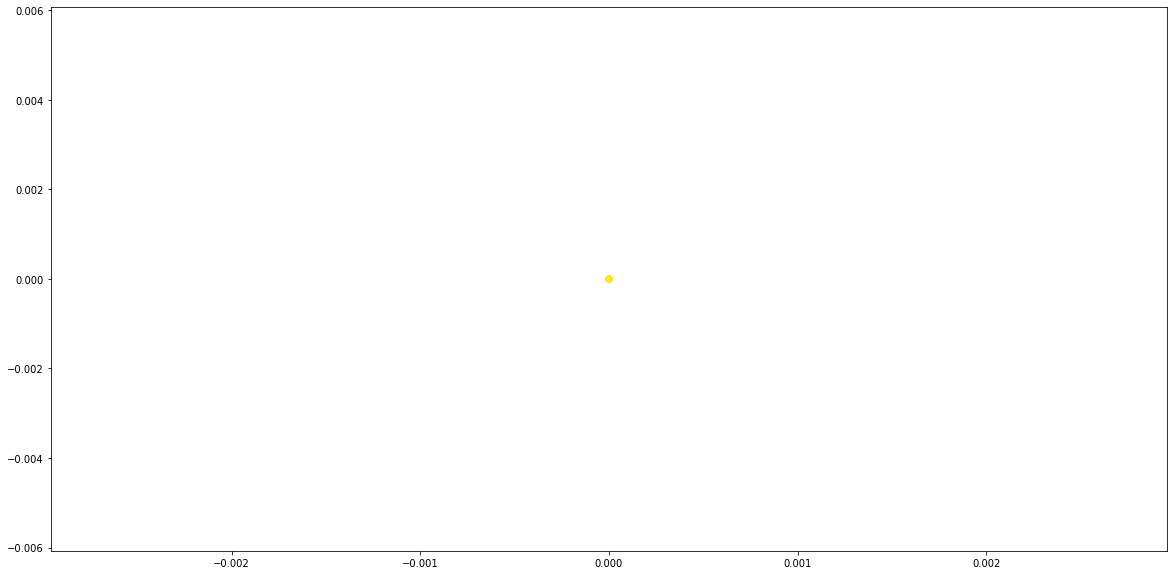

In [20]:
z = test(model_ae)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,0], z[:,1], c=np.arange(rna.shape[0]))

## Variational AutoEncoder

In [25]:
data_loader = DataLoader(dataset, shuffle=True, batch_size=32)

model_vae = model.vae.VAE(in_channels_atac=1000, in_channels_rna=rna.shape[1], latent_channels_atac=8, latent_channels_rna=8, latent_channels_z=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.01)

for epoch in range(0, 51):

    loss = train(model)
    if epoch % 10 == 0:
        print("Epoch: ", epoch, "loss:", loss)

Epoch:  0 loss: 1.5221446917301684
Epoch:  10 loss: 0.035532716276608645
Epoch:  20 loss: 0.035580659264734596
Epoch:  30 loss: 0.035440455779393754
Epoch:  40 loss: 0.03528248600235765
Epoch:  50 loss: 0.035296485262447934


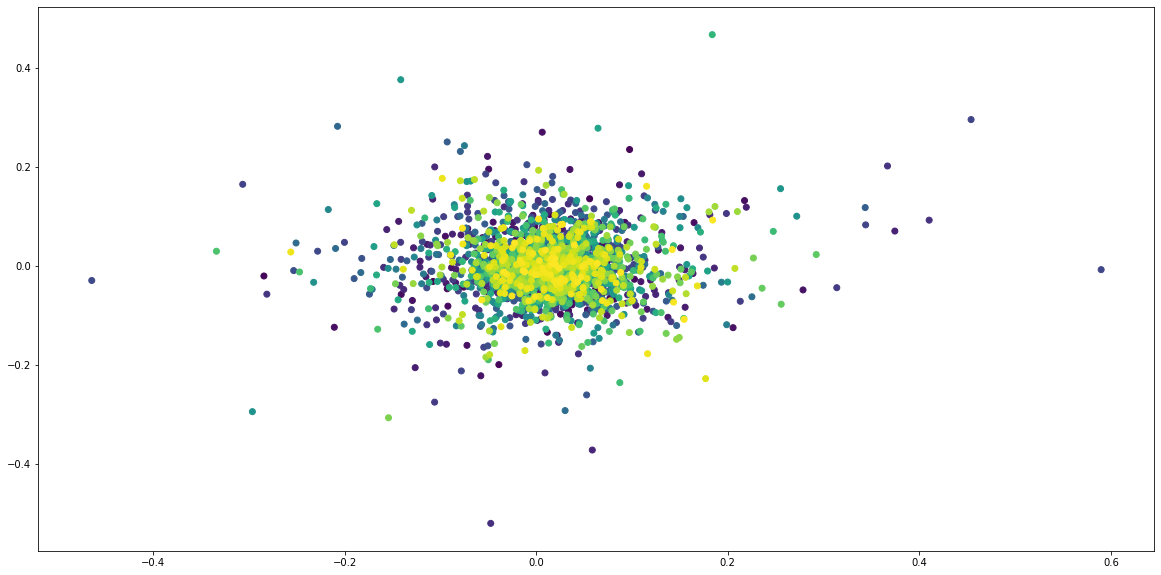

In [32]:
z = test(model_vae)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,0], z[:,1], c=np.arange(rna.shape[0]))